## Purpose

This code is designed to generate synthetic data with more random characterics than is provided by the BMS dataset. This could be used to aid the robustness of algorithms created to tackle the BMS task and other related tasks.

For the background disussion, refer to: https://www.kaggle.com/c/bms-molecular-translation/discussion/225590 .

Updates for the 2nd edition:
  - resulting outpus are closer to the original dataset
  - support InChI inputs (not just SMILES)
  - font scaling now actually works (in the previous version, additional random diagram scaling made it look as if font scaling was working)
  - replaced hacky SVG manipulation code for dropping bonds and changing fonts with code using lxml
  - outputs also include the unaugmented image, given in two layers: one for the atoms and one for the bonds
  - result are shown actual size and compared with image from the original dataset.
 
Updates for 3rd edition:
  - a slight tweak to stretch the value range of output values of the (unaugmented) atom and bond images to fit exactly in the range 0 to 1

In [4]:
print('Installing RDKit. This can take a while ...')
# We use a specific version of RDKit with known working font scaling.
!conda config --append channels conda-forge
!conda install -q -y -c rdkit rdkit=2020_03_6
print('DONE.')

Installing RDKit. This can take a while ...
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - alabaster -> python[version='2.7.*|3.5.*|3.6.*|>=2.7,<2.8.0a0|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0|>=3.5,<3.6.0a0|3.4.*']
  - anaconda==2020.11 -> python[version='3.7.9|3.8.5',build='h7579374_1|h7579374_0']
  - argon2-cffi -> python[version='2.7.*|3.5.*|3.6.*|3.6.12|3.6.12|3.7.10|>=3.5,<3.6.0a0|3.7.9|3.6.9|3.6.9|3.6.9|3.6.9|3.4.*|3.7.*|3.9.*|3.8.*',build='1_73_pypy|4_73_pypy|5_73_pypy|5_73_pypy|0_73_pypy|3_73_pypy|2_73_pypy|0_73_pypy']
  - atomicwrit

In [1]:
from pathlib import Path
from io import BytesIO
import re
import copy
import logging

import numpy as np
import pandas as pd

import lxml.etree as et
import cssutils

from PIL import Image
import cairosvg
from skimage.transform import resize

import IPython
from IPython.display import SVG
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import MolDrawOptions

ModuleNotFoundError: No module named 'rdkit'

In [4]:
PROJECT_DIR = Path('..')
INPUT_DIR = PROJECT_DIR / 'input' / 'bms-molecular-translation'
TMP_DIR = PROJECT_DIR / 'tmp'
TRAIN_DATA_PATH = INPUT_DIR / 'train'
TRAIN_LABELS_PATH = INPUT_DIR / 'train_labels.csv'
TMP_DIR.mkdir(exist_ok=True)

cssutils.log.setLevel(logging.CRITICAL)

np.set_printoptions(edgeitems=30, linewidth=180)
print('RDKit version:', rdkit.__version__)
# Use a specific version of RDKit with known characteristics so that we can reliably manipulate output SVG.
assert rdkit.__version__ == '2020.03.6'

TRAIN_LABELS = pd.read_csv(TRAIN_LABELS_PATH)
print(f'Read {len(TRAIN_LABELS)} training labels.')

RDKit version: 2020.03.6
Read 2424186 training labels.


## Implementation

We vary the drawing properties, the font, and occassionally drop bond lines.

In [5]:
def one_in(n):
    return np.random.randint(n) == 0 and True or False


def yesno():
    return one_in(2)


def svg_to_image(svg, convert_to_greyscale=True):
    svg_str = et.tostring(svg)
    # TODO: would prefer to convert SVG dirrectly to a numpy array.
    png = cairosvg.svg2png(bytestring=svg_str)
    image = np.array(Image.open(BytesIO(png)), dtype=np.float32)
    # Naive greyscale conversion.
    if convert_to_greyscale:
        image = image.mean(axis=-1)
    return image


def elemstr(elem):
    return ', '.join([item[0] + ': ' + item[1] for item in elem.items()])


# Streches the value range of an image to be exactly 0, 1, unless the image appears to be blank.
def stretch_image(img, blank_threshold=1e-2):
    img_min = img.min()
    img = img - img_min
    img_max = img.max()
    if img_max < blank_threshold:
        # seems to be blank or close to it
        return img
    img_max = img.max()
    if img_max < 1.0:
        img = img/img_max
    return img


def random_molecule_image(inchi, drop_bonds=True, add_noise=True, render_size=1200, margin_fraction=0.2):
    # Note that the original image is returned as two layers: one for atoms and one for bonds.
    #mol = Chem.MolFromSmiles(smiles)
    mol = Chem.inchi.MolFromInchi(inchi)
    d = Draw.rdMolDraw2D.MolDraw2DSVG(render_size, render_size)
    options = MolDrawOptions()
    options.useBWAtomPalette()
    options.additionalAtomLabelPadding = np.random.uniform(0, 0.3)
    options.bondLineWidth = int(np.random.uniform(1, 4))
    options.multipleBondOffset = np.random.uniform(0.05, 0.2)
    options.rotate = np.random.uniform(0, 360)
    options.fixedScale = np.random.uniform(0.05, 0.07)
    options.minFontSize = 20
    options.maxFontSize = options.minFontSize + int(np.round(np.random.uniform(0, 36)))
    d.SetFontSize(100)
    d.SetDrawOptions(options)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    svg_str = d.GetDrawingText()
    # Do some SVG manipulation
    svg = et.fromstring(svg_str.encode('iso-8859-1'))
    atom_elems = svg.xpath(r'//svg:text', namespaces={'svg': 'http://www.w3.org/2000/svg'})
    bond_elems = svg.xpath(r'//svg:path[starts-with(@class,"bond-")]', namespaces={'svg': 'http://www.w3.org/2000/svg'})
    # Change the font.
    font_family = np.random.choice([
        'serif',
        'sans-serif'
    ])
    for elem in atom_elems:
        style = elem.attrib['style']
        css = cssutils.parseStyle(style)
        css.setProperty('font-family', font_family)
        css_str = css.cssText.replace('\n', ' ')
        elem.attrib['style'] = css_str
    # Create the original image layers.
    # TODO: separate atom and bond layers
    bond_svg = copy.deepcopy(svg)
    # remove atoms from bond_svg
    for elem in bond_svg.xpath(r'//svg:text', namespaces={'svg': 'http://www.w3.org/2000/svg'}):
        parent_elem = elem.getparent()
        if parent_elem is not None:
            parent_elem.remove(elem)
    orig_bond_img = svg_to_image(bond_svg)
    atom_svg = copy.deepcopy(svg)
    # remove bonds from atom_svg
    for elem in atom_svg.xpath(r'//svg:path', namespaces={'svg': 'http://www.w3.org/2000/svg'}):
        parent_elem = elem.getparent()
        if parent_elem is not None:
            parent_elem.remove(elem)
    orig_atom_img = svg_to_image(atom_svg)
    if drop_bonds:
        num_bond_elems = len(bond_elems)
        if one_in(3):
            while True:
                # drop a bond
                # Let's leave at least one bond!
                if num_bond_elems > 1:
                    bond_elem_idx = np.random.randint(num_bond_elems)
                    bond_elem = bond_elems[bond_elem_idx]
                    bond_parent_elem = bond_elem.getparent()
                    if bond_parent_elem is not None:
                        bond_parent_elem.remove(bond_elem)
                        num_bond_elems -= 1
                else:
                    break
                if not one_in(4):
                    break
    img = svg_to_image(svg) > 254
    img = 1*img  # bool → int
    # Calculate the margins.
    black_indices = np.where(img == 0)
    row_indices, col_indices = black_indices
    if len(row_indices) >= 2:
        min_y, max_y = row_indices.min(), row_indices.max() + 1
    else:
        min_y, max_y = 0, render_size
    if len(col_indices) >= 2:
        min_x, max_x = col_indices.min(), col_indices.max() + 1
    else:
        min_x, max_x = 0, render_size
    margin_size = int(np.random.uniform(0.8*margin_fraction, 1.2*margin_fraction)*max(max_y - min_y, max_x - min_x))
    min_y, max_y = max(min_y - margin_size, 0), min(max_y + margin_size, render_size)
    min_x, max_x = max(min_x - margin_size, 0), min(max_x + margin_size, render_size)
    img = img[min_y:max_y, min_x:max_x]
    img = img.reshape([img.shape[0], img.shape[1]]).astype(np.float32)
    orig_bond_img = orig_bond_img[min_y:max_y, min_x:max_x]
    orig_atom_img = orig_atom_img[min_y:max_y, min_x:max_x]
    scale = np.random.uniform(0.2, 0.4)
    sz = (np.array(orig_bond_img.shape[:2], dtype=np.float32)*scale).astype(np.int32)
    orig_bond_img = resize(orig_bond_img, sz, anti_aliasing=True)
    orig_atom_img = resize(orig_atom_img, sz, anti_aliasing=True)
    img = resize(img, sz, anti_aliasing=False)
    img = img > 0.5
    if add_noise:
        # Add "salt and pepper" noise.
        salt_amount = np.random.uniform(0, 0.3)
        salt = np.random.uniform(0, 1, img.shape) < salt_amount
        img = np.logical_or(img, salt)
        pepper_amount = np.random.uniform(0, 0.001)
        pepper = np.random.uniform(0, 1, img.shape) < pepper_amount
        img = np.logical_or(1 - img, pepper)
    
    img = img.astype(np.uint8)  # boolean -> uint8
    orig_bond_img = 1 - orig_bond_img/255
    orig_atom_img = 1 - orig_atom_img/255
    # Stretch the range of the atom and bond images so tha tthe min is 0 and the max. is 1
    orig_bond_img = stretch_image(orig_bond_img)
    orig_atom_img = stretch_image(orig_atom_img)
    return img, orig_bond_img, orig_atom_img

## Tests

714 ms ± 194 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
+-------------------------------------------------------------------------------
Molecule #1: 008136e5b9fe: InChI=1S/C13H15NO2/c1-10(14-11(2)16)13-7-5-12(6-8-13)4-3-9-15/h5-8,10,15H,9H2,1-2H3,(H,14,16)
Training image path: ../input/bms-molecular-translation/train/0/0/8/008136e5b9fe.png
Size: (387, 387)


Image from training data:
Size: (284, 124)


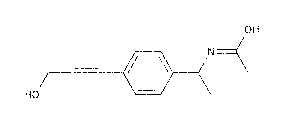

+-------------------------------------------------------------------------------
Molecule #2: 64b4428ff891: InChI=1S/C12H12N4O3S/c17-10-2-1-3-14-16(10)8-11(18)15-6-9(7-15)19-12-13-4-5-20-12/h1-5,9H,6-8H2
Training image path: ../input/bms-molecular-translation/train/6/4/b/64b4428ff891.png
Size: (376, 220)


Image from training data:
Size: (438, 217)


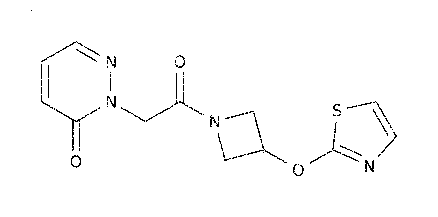

+-------------------------------------------------------------------------------
Molecule #3: d1e3d3a9dcd8: InChI=1S/C9H6N4O2/c14-9(15)13-4-10-8-5-3-11-12-6(5)1-2-7(8)13/h1-3H,4H2,(H,14,15)
Training image path: ../input/bms-molecular-translation/train/d/1/e/d1e3d3a9dcd8.png
Size: (330, 223)


Image from training data:
Size: (208, 135)


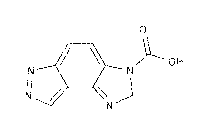

+-------------------------------------------------------------------------------
Molecule #4: 9bd66353c563: InChI=1S/C15H21N3/c1-17-9-10-18(13-15(11-17)7-8-16)12-14-5-3-2-4-6-14/h2-6,15H,7,9-13H2,1H3
Training image path: ../input/bms-molecular-translation/train/9/b/d/9bd66353c563.png
Size: (262, 250)


Image from training data:
Size: (254, 155)


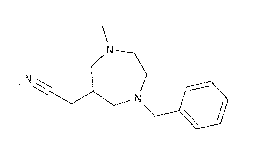

+-------------------------------------------------------------------------------
Molecule #5: dea7d6101b64: InChI=1S/C38H40N4O6S2/c43-35-25-47-31-17-5-1-13-27(31)37(45)39-21-9-10-22-40-38(46)28-14-2-6-18-32(28)48-26-36(44)42-30-16-4-8-20-34(30)50-24-12-11-23-49-33-19-7-3-15-29(33)41-35/h1-8,13-20H,9-12,21-26H2,(H,39,45)(H,40,46)(H,41,43)(H,42,44)
Training image path: ../input/bms-molecular-translation/train/d/e/a/dea7d6101b64.png
Size: (308, 308)


Image from training data:
Size: (346, 306)


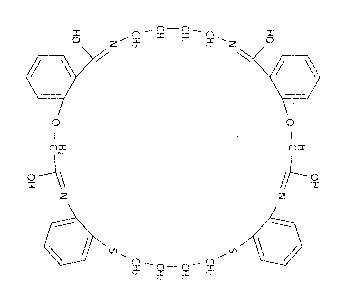

+-------------------------------------------------------------------------------
Molecule #6: 734911f39c0e: InChI=1S/C22H21N5O3/c28-20-13-23-16-5-1-3-7-18(16)26(20)14-21(29)25-11-9-15(10-12-25)27-19-8-4-2-6-17(19)24-22(27)30/h1-8,13,15H,9-12,14H2,(H,24,30)
Training image path: ../input/bms-molecular-translation/train/7/3/4/734911f39c0e.png
Size: (388, 279)


Image from training data:
Size: (299, 186)


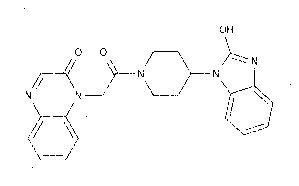

+-------------------------------------------------------------------------------
Molecule #7: c04b49da81ee: InChI=1S/C15H22O4S/c1-11-8-6-7-9-13(11)10-20(17,18)12(2)14(16)19-15(3,4)5/h6-9,12H,10H2,1-5H3
Training image path: ../input/bms-molecular-translation/train/c/0/4/c04b49da81ee.png
Size: (306, 204)


Image from training data:
Size: (394, 202)


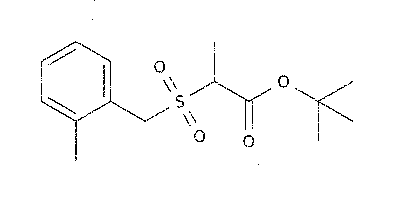

+-------------------------------------------------------------------------------
Molecule #8: ca479161881c: InChI=1S/C15H22N4O3/c1-21-15(20)11-2-3-12(8-11)18-13-9-14(17-10-16-13)19-4-6-22-7-5-19/h9-12H,2-8H2,1H3,(H,16,17,18)/t11-,12+/m0/s1
Training image path: ../input/bms-molecular-translation/train/c/a/4/ca479161881c.png
Size: (322, 375)


Image from training data:
Size: (266, 173)


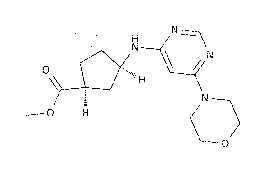

+-------------------------------------------------------------------------------
Molecule #9: 1bdf59ab3ca5: InChI=1S/C24H24FN5/c25-20-7-6-18-9-10-29(22(18)13-20)16-21-12-19-15-27-23(14-26)28-24(19)30(21)11-8-17-4-2-1-3-5-17/h6-7,9-10,12-13,15,17H,1-5,8,11,16H2
Training image path: ../input/bms-molecular-translation/train/1/b/d/1bdf59ab3ca5.png
Size: (434, 467)


Image from training data:
Size: (296, 232)


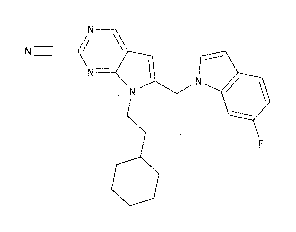

+-------------------------------------------------------------------------------
Molecule #10: 097cd27d5c10: InChI=1S/C20H14ClFN6/c1-28-9-12(18-26-15-4-2-3-5-16(15)27-18)17-19(23-10-24-20(17)28)25-11-6-7-14(22)13(21)8-11/h2-10H,1H3,(H,26,27)(H,23,24,25)
Training image path: ../input/bms-molecular-translation/train/0/9/7/097cd27d5c10.png
Size: (330, 347)


Image from training data:
Size: (246, 224)


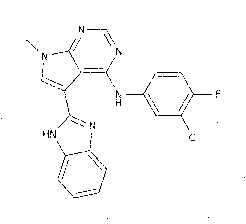

+-------------------------------------------------------------------------------
Molecule #11: 8aaca3ff875d: InChI=1S/C11H22ClNO2S/c1-11-10-16(14,15)9-8-13(11)7-5-3-2-4-6-12/h11H,2-10H2,1H3
Training image path: ../input/bms-molecular-translation/train/8/a/a/8aaca3ff875d.png
Size: (310, 163)


Image from training data:
Size: (445, 226)


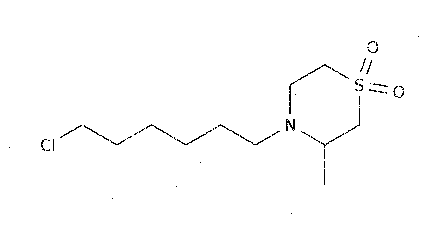

+-------------------------------------------------------------------------------
Molecule #12: c3b3ed26aa08: InChI=1S/C45H75NO/c1-3-5-7-9-11-13-15-17-18-19-20-22-24-26-28-30-40-47-45-38-34-43(35-39-45)41-46-44-36-32-42(33-37-44)31-29-27-25-23-21-16-14-12-10-8-6-4-2/h32-39,41H,3-31,40H2,1-2H3
Training image path: ../input/bms-molecular-translation/train/c/3/b/c3b3ed26aa08.png
Size: (355, 406)


Image from training data:
Size: (1468, 229)


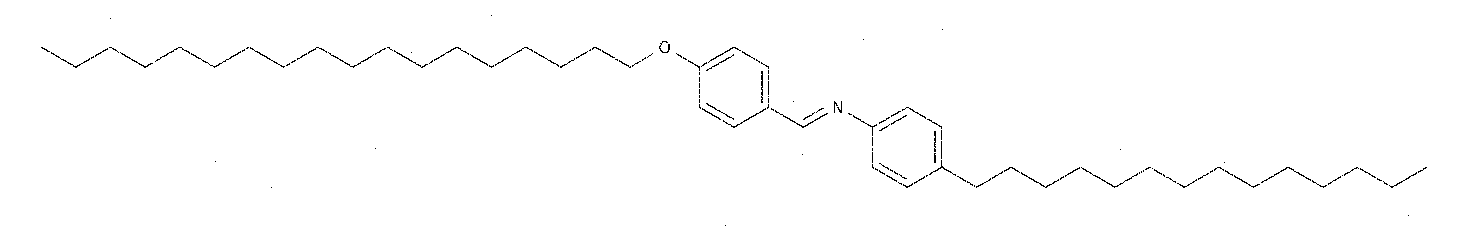

+-------------------------------------------------------------------------------
Molecule #13: 3399a6eed7ca: InChI=1S/C22H30O5/c1-4-5-6-7-8-16(2)15-17(3)9-11-19(23)18-10-14-22(26)27-20(18)12-13-21(24)25/h9-16,18,20H,4-8H2,1-3H3,(H,24,25)/t16-,18+,20-/m0/s1
Training image path: ../input/bms-molecular-translation/train/3/3/9/3399a6eed7ca.png
Size: (425, 420)


Image from training data:
Size: (369, 194)


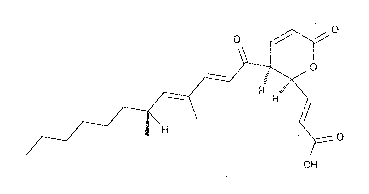

+-------------------------------------------------------------------------------
Molecule #14: d02af749fc42: InChI=1S/C15H25N3O3/c1-15(21-2,12-5-6-12)9-16-14(20)18-8-7-17(10-18)13(19)11-3-4-11/h11-12H,3-10H2,1-2H3,(H,16,20)
Training image path: ../input/bms-molecular-translation/train/d/0/2/d02af749fc42.png
Size: (230, 257)


Image from training data:
Size: (287, 146)


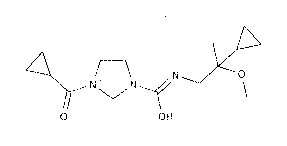

+-------------------------------------------------------------------------------
Molecule #15: 7c7aca99ea59: InChI=1S/C17H16F4N2O2S/c18-13-5-1-2-6-14(13)22-9-11-23(12-10-22)15-7-3-4-8-16(15)26(24,25)17(19,20)21/h1-8H,9-12H2
Training image path: ../input/bms-molecular-translation/train/7/c/7/7c7aca99ea59.png
Size: (298, 412)


Image from training data:
Size: (403, 262)


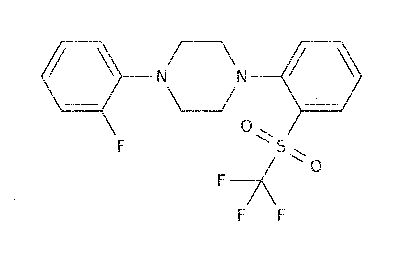

+-------------------------------------------------------------------------------
Molecule #16: 722232583a40: InChI=1S/C16H12Cl2N4S/c1-10-3-2-4-11(7-10)9-19-22-15(20-21-16(22)23)13-6-5-12(17)8-14(13)18/h2-9H,1H3,(H,21,23)/b19-9-
Training image path: ../input/bms-molecular-translation/train/7/2/2/722232583a40.png
Size: (216, 295)


Image from training data:
Size: (443, 251)


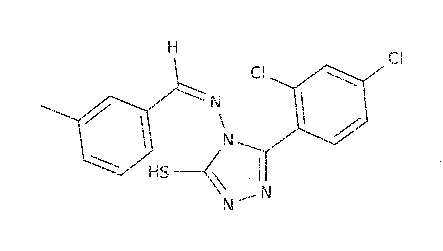

+-------------------------------------------------------------------------------
Molecule #17: 2f8a7a03e406: InChI=1S/C17H22N2/c1-19(2)13-12-18-17-11-7-6-10-16(17)14-15-8-4-3-5-9-15/h3-11,18H,12-14H2,1-2H3
Training image path: ../input/bms-molecular-translation/train/2/f/8/2f8a7a03e406.png
Size: (254, 253)


Image from training data:
Size: (252, 160)


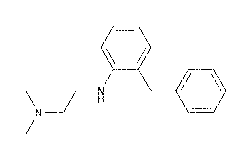

+-------------------------------------------------------------------------------
Molecule #18: 71749928f488: InChI=1S/C20H22N2O3/c1-14-3-7-16(8-4-14)20(24)21-11-18-12-22(19(23)13-25-18)17-9-5-15(2)6-10-17/h3-10,18H,11-13H2,1-2H3,(H,21,24)
Training image path: ../input/bms-molecular-translation/train/7/1/7/71749928f488.png
Size: (403, 352)


Image from training data:
Size: (533, 229)


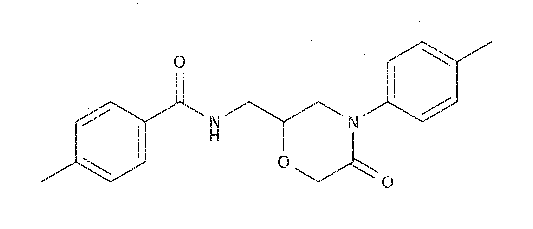

+-------------------------------------------------------------------------------
Molecule #19: f0faf3128e72: InChI=1S/C20H16F3NO4/c1-11-8-18(25)28-17-10-15(6-7-16(11)17)27-12(2)19(26)24-14-5-3-4-13(9-14)20(21,22)23/h3-10,12H,1-2H3,(H,24,26)
Training image path: ../input/bms-molecular-translation/train/f/0/f/f0faf3128e72.png
Size: (397, 465)


Image from training data:
Size: (360, 164)


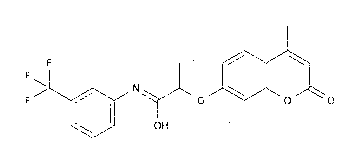

+-------------------------------------------------------------------------------
Molecule #20: ed004e368dcc: InChI=1S/C19H18N6O5/c1-11(18(27)28)23-6-7-25(19(23)29)13-4-2-12(3-5-13)24-8-9-30-16-14(17(24)26)15(20)21-10-22-16/h2-7,10-11H,8-9H2,1H3,(H,27,28)(H2,20,21,22)
Training image path: ../input/bms-molecular-translation/train/e/d/0/ed004e368dcc.png
Size: (255, 367)


Image from training data:
Size: (342, 164)


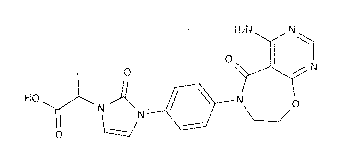

In [6]:
def image_widget(a, greyscale=True):
    img_bytes = BytesIO()
    img_pil = Image.fromarray(a)
    if greyscale:
        img_pil = img_pil.convert("L")
    else:
        img_pil = img_pil.convert("RGB")
    img_pil.save(img_bytes, format='PNG')
    return widgets.Image(value=img_bytes.getvalue())


def test_random_molecule_image(n=4, graphics=True):
    for imol in range(n):
        #smiles = np.random.choice(some_smiles)
        mol_index = np.random.randint(len(TRAIN_LABELS))
        mol_id, inchi = TRAIN_LABELS['image_id'][mol_index], TRAIN_LABELS['InChI'][mol_index]
        mol_train_img_path = TRAIN_DATA_PATH / mol_id[0] /mol_id[1] / mol_id[2] / (mol_id + '.png')
        train_img = Image.open(mol_train_img_path)
        img, orig_bond_img, orig_atom_img = random_molecule_image(inchi)
        if graphics:
            print('+-------------------------------------------------------------------------------')
            print(f'Molecule #{imol + 1}: {mol_id}: {inchi}')
            print('Training image path:', mol_train_img_path)
            print('Size:', img.shape)
            combined_orig_img =  np.clip(np.stack([orig_atom_img, orig_bond_img, np.zeros_like(orig_bond_img)], axis=-1), 0.0, 1.0)
            combined_orig_img = (255*combined_orig_img).astype(np.uint8)
            widget1 = image_widget(combined_orig_img, greyscale=False)
            widget2 = image_widget((255*(1 - img)).astype(np.uint8))
            sidebyside = widgets.HBox([widget1, widget2])
            display(sidebyside)
            print(f'Image from training data:')
            print('Size:', train_img.size)
            display(train_img)
    return


%timeit -n1 -r10 test_random_molecule_image(n=1, graphics=False)
test_random_molecule_image(n=20, graphics=True)